## Theory

Source:\
EU Capital Requirements Regulation (CRR) - http://www.eba.europa.eu/regulation-and-policy/single-rulebook/interactive-single-rulebook/toc/504

The **CVA (Credit Valuation Adjustment)** is defined as the difference between the risk-free value and the risky value. 
Or alternatively as the expected loss arising from a future counterparty defaulting.

$$
CVA = LGD_{MKT} 
\sum_{i=1}^T 
max \bigg\{ 0, 
exp \big( - \frac {s_{i-1} \cdot t_{i-1}}{LGD_{MKT}} \big) 
- exp \big(- \frac{s_{i} \cdot t_{i}}{LGD_{MKT}} \big) \bigg\} 
\cdot \frac {EE_{i-1} \cdot D_{i-1} + EE_i \cdot D_i}{2}
$$

where,\
$t_i$, the time of i-th revaluation\
$T$, the longest contractual maturity across the netting sets with the counterparty\
$s_i$, the credit spread of the counterparty at tenor $t_i$ 
(the credit default swap spread of counterparty, if available; 
if not, an approprite proxy spread with regard to the rating, industry and region of the counterparty)\
$LGD_{MKT}$, LGD of the counterparty (based on the spread of market instruments of the counterparty, if available; if not, a proxy spread)\
$EE_i$, Expected Exposure to the counterparty at revaluation time $t_i$ (exposures of different netting sets for the counterparty are added)
$D_i$, the default risk-free discount factor at time $t_i$ ($D_0$ = 1)\
$RR = 1 - LGD_{MKT}$, Recovery

## Probability of Default, Analytical vs MC simulations

In the **Merton structural model**, the value of the firms value/equity at time T is $E_T = max(A_T − D, 0)$, where the debt value at t = 0 is $D_0 = A_0 − E_0$.

The equity can be interpreted as a call option on the value of the assets with a strike price equal to the debt. The Black-Scholes formula can be used to obtain the value of the equity at time t = 0. 
> $ E_0 = A_0 N(d_1) - De^{-rT}\ N(d_2) $

where<br>
$ d_1 = \frac{1}{σ_A \sqrt T } \big[ log \frac{A_0}{D}\ \ +\ \ (r + \frac{σ^2_A}{2})\ T \big] $<br>
$ d_2 = d_1 - σ_A \sqrt{T} $<br>
$ N(d_1) = norm.cdf(d_1,0,1) $<br>
$ N(d_2) = norm.cdf(d_2,0,1) $<br>

Because of the equivalence $\frac{\partial E}{\partial A} = N(d_1)$, we get

> $ \sigma_E E_0 = N(d_1)\sigma_A A_0 $

The probability of default in the Merton model is 
> $ PD^M = 1 - N(d_2) = N(-d_2) $

In the **Black-Cox model**, the probability of default from time t to time T is 
> $ PD^{BC}[\tau \le T | \tau \gt t] = N(h_1) + exp \bigg\{ 2\big( r - \frac {\sigma^2_A}{2} \big) ln \big( \frac{K}{A_t} \big) \frac {1}{\sigma_A^2} \bigg\} \ N(h_2) $

where<br>
$ h_1 = \frac {1}{\sigma_A \sqrt{T - t}} \ \bigg[ ln \big( \frac  {K}{e^{r(T - t)}A_t} \big) + \frac {\sigma_A^2}{2} (T - t) \bigg] $<br>
$ h_2 = h_1 - \sigma_A \sqrt{T - t} $<br>

To computine **PD using Monte Carlo simulations**, we can use the Euler's discretization of Black-Scholes-Merton SDE, i.e. the firm's lognormal asset value evolves according to the following eq.

> $A_{t+1} = A_t\ exp\big( (r - \frac{σ_A^2}{2}) dt \ +  \ σ_A \sqrt{dt}\ z\big)$

Given, counterparty's equity E of \\$3 million, volatility $σ_E$ of is 50%, debt of $5 million maturing in 1 year, the risk-free rate of 2%

In [11]:
from scipy.stats import norm
from scipy.optimize import minimize, least_squares

Eo = 15  # Equity = 15 million at time t = 0
Evol= .7 # equity's volatility = 70%
DT = 10 # notional debt = 10 million due in time T
T = 5 # debt time maturity = 1Y
rf = .005 # risk-free rate = 0.5%

In [12]:
# compute the assets' value Vo and volatility Vvol

def function_to_minimize_Ao_and_Avol(a):
    """the function is used iteratively to minimize the input parameters
    
    Parameters
        a: an array of initial values to minimize
    Returns
        v1, v2: the resultant minimized values
    """
    Ao__, Avol__= a[0], a[1]
    
    d1 = 1/(Avol__*np.sqrt(T)) * (np.log(Ao__/DT) + (rf + Avol__**2/2)*T) 
    d2 = d1 - Avol__*np.sqrt(T)
    N1 = norm.cdf(d1,0,1)
    N2 = norm.cdf(d2,0,1)
    
    # minimize the following to zeros
    v1_to_minimize = Eo - (Ao__ * N1 - DT * np.exp(-rf*T) * N2)
    v2_to_minimize = Evol - (N1 * Avol__ * Ao__ / Eo)
    
    return np.array([v1_to_minimize, v2_to_minimize])


# initialize arbitraily with Vo_ = Eo + DT and Vvol_ = Evol
res = least_squares(function_to_minimize_Ao_and_Avol, [Eo + DT, Evol])
Ao, Avol = res.x
# show the results of the optimization
print("Optimization Results:")
res

Optimization Results:


 active_mask: array([0., 0.])
        cost: 1.1002883994602944e-27
         fun: array([-4.61852778e-14,  8.21565038e-15])
        grad: array([4.14932058e-14, 3.85510529e-13])
         jac: array([[-0.90479713, -8.58282757],
       [-0.03591939, -1.32548812]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 5
        njev: 5
  optimality: 3.855105287672361e-13
      status: 1
     success: True
           x: array([22.67404232,  0.51181043])

In [13]:
f"The assets' value Ao is {Ao:.3f} millions, and volatility Avol is {100*Avol:.2f}%."

"The assets' value Ao is 22.674 millions, and volatility Avol is 51.18%."

In [14]:
Avol = np.arange(10,100+1,10)/100 # the range of assets' volatilities
K = 5 # strike or default threshold

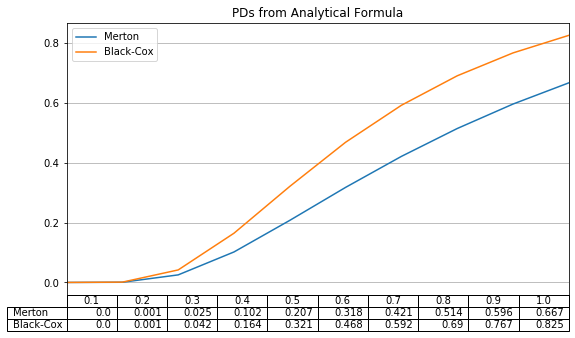

In [17]:
### compute Merton PDs
d1 = 1/(Avol*np.sqrt(T)) * (np.log(Ao/K) + (rf + Avol**2/2)*T) 
d2 = d1 - Avol*np.sqrt(T)
PD_Merton = norm.cdf(-d2,0,1)

# compute Black-Cox PDs
h1 = (np.log(K/(np.exp(rf*T)*Ao)) + (0.5*Avol**2) * T) / (Avol * np.sqrt(T))
h2 = h1 - Avol * np.sqrt(T)
PD_BlackCox = norm.cdf(h1,0,1) + np.exp(2*(rf-Avol**2/2)*np.log(K/Ao)/Avol**2) * norm.cdf(h2,0,1)

# merge the dataframes
analytic_df = pd.merge( pd.DataFrame(PD_Merton,Avol,['Merton']), pd.DataFrame(PD_BlackCox,Avol,['Black-Cox']),
                        left_index=True, right_index=True )
analytic_df.index.name = 'σ_A'

# plot the data
ax = plt.gca()
ax.get_xaxis().set_visible(False)
analytic_df.plot(table=np.round(analytic_df.T, 3),ax=ax,figsize=(9,5))
plt.grid(True)
plt.title("PDs from Analytical Formula");

In [18]:
def mc_PD(Ao, Avol, K, rf, T, Ts=260, N=10000):
    """Computes the Black-Cox PD with numerical (simulation-based) MC simulation.
    
    Parameters
        Ao: initial assets' value
        Avol:  assets' volatility
        K:  default threshold
        rf:  constant risk-free short rate
        T:  maturity date (in year fractions)
        Ts: default=260 (assuming 260 trading days a year)
            num of time steps; the higher the num the closer the ret value is to continuus approximation 
        N:  default=10000
            num of simulated paths

    Returns
        PDs: the tuple of Merton and Black-Cox PDs
            
    """
    #assert model in ('M','BC'), 'only Merton and Black-Cox structural models implemented'
  
    dt = T / Ts # time step
    A = np.zeros((Ts + 1, N))
    A[0] = Ao
    
    # Euler's discretization of BSM SDE
    for t in range(1, Ts + 1):
        z = np.random.standard_normal(N)  
        A[t] = A[t-1] * np.exp( (rf - 0.5 * Avol**2)*dt  +   Avol*np.sqrt(dt)*z )

    PD_M = np.mean( np.where( A[-1] < K, 1, 0) )
    PD_BC = np.mean( np.any( np.minimum( A - K, 0) < 0, axis=0) )
    # PD_BC = np.mean( np.sign( np.sum( np.minimum( A - K, 0) < 0, axis=0) ))

    return PD_M, PD_BC


# show the diff between the analytic and MC values for one Avol
σ_A=.5
Analytic_MC_Diffs = analytic_df.query("σ_A == %f" % σ_A).values - mc_PD(Ao=7.899, Avol=σ_A, K=5, rf=.02, T=1)
print(("The differences between the Analytic and Monte-Carlo computations for\n"
       "the Merton and Black-Cox PDs are {d[0]:.5f} and {d[1]:.5f},respectively. " 
       .format(d=Analytic_MC_Diffs.squeeze())))

The differences between the Analytic and Monte-Carlo computations for
the Merton and Black-Cox PDs are -0.03981 and -0.09784,respectively. 


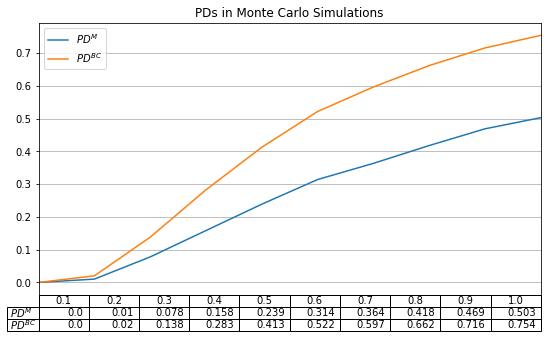

In [20]:
# assemble the dataframe
ary = []
for Avol in np.arange(10,100+1,10)/100:
    ary.append([Avol, *mc_PD(Ao=7.899, Avol=Avol, K=5, rf=.02, T=1)])
    
mc_df = pd.DataFrame(ary,columns=['σ_A','$PD^M$','$PD^{BC}$']).set_index('σ_A')

# plot the data
ax = plt.gca()
ax.get_xaxis().set_visible(False)
mc_df.plot(table=np.round(mc_df.T, 3),ax=ax,figsize=(9,5))
plt.grid(True)
plt.title("PDs in Monte Carlo Simulations");

###### THE END